In [ ]:
!pip install --upgrade pymorphy2
!pip install --upgrade pymorphy2-dicts
!pip install --upgrade gensim
!pip install --upgrade pyLDAvis

     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 7.1MB 15.8MB/s 
Requirement already up-to-date: pymorphy2-dicts in /usr/local/lib/python3.6/dist-packages (2.4.393442.3710985)
     |████████████████████████████████| 24.2MB 1.7MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.6MB 8.0MB/s 
     |████████████████████████████████| 552kB 45.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=1d34c6b15e65281bab13e1118d75150de16a8852fb858e76ed6d13fb8d1356e8
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=146e6de3dc32005ab3f35f46db9a7717676e71493720465b8d2de5da1f1cf62c
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfd

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import numpy as np


import string
import re
from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('russian') #this depends on each language

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [ ]:
data = pd.read_excel('data.xlsx', sheet_name = 0)
text = data['Отзыв '].values

In [ ]:
text = data['Отзыв '].values.tolist()

In [ ]:
pprint(text[:1])

['Я получила, хорошее представление о том, что вообще такое машинное обучение, '
 'и некую начальную теор базу. Почти под любую тему есть ссылка на '
 'соответствующие полноценные написанные лекции, которые очень помогали '
 'получить более широкую картину. И самое главное были интересные и полезные '
 'практические задания.']


In [ ]:
print(stopWords)
my_stopWords = {'который', 'какой','нельзя','всегда','больше','имхо','николай','мой','это','некоторый','другой','также','этот','кроме','таким образом','тот','хотя','например','анатолий','то есть','такой'}
del_words = { 'лучше','хорошо', 'много', 'более', 'больше', 'великий_великий'}
all_stopWords = stopWords.union(my_stopWords)
all_stopWords.difference_update(del_words)
print(all_stopWords)

{'на', 'она', 'вот', 'другой', 'них', 'про', 'будет', 'того', 'разве', 'чем', 'здесь', 'этом', 'даже', 'потом', 'было', 'нас', 'мы', 'какой', 'там', 'чтоб', 'два', 'свою', 'более', 'хоть', 'моя', 'но', 'этой', 'о', 'над', 'он', 'всегда', 'тогда', 'если', 'нее', 'или', 'опять', 'между', 'тут', 'да', 'при', 'можно', 'почти', 'чего', 'вам', 'ничего', 'больше', 'много', 'его', 'с', 'этого', 'со', 'нибудь', 'раз', 'ней', 'к', 'во', 'мой', 'три', 'него', 'этот', 'ли', 'были', 'теперь', 'ему', 'для', 'совсем', 'по', 'уже', 'за', 'ей', 'эти', 'хорошо', 'надо', 'себе', 'из', 'без', 'только', 'тот', 'их', 'быть', 'что', 'вдруг', 'зачем', 'в', 'какая', 'все', 'как', 'ну', 'чуть', 'может', 'ни', 'лучше', 'им', 'не', 'они', 'перед', 'я', 'а', 'уж', 'вас', 'потому', 'такой', 'будто', 'себя', 'бы', 'была', 'есть', 'после', 'нельзя', 'том', 'через', 'ж', 'у', 'мне', 'меня', 'ты', 'нет', 'тем', 'вы', 'ее', 'ведь', 'и', 'где', 'когда', 'кто', 'до', 'всего', 'никогда', 'эту', 'всю', 'сам', 'наконец', 'чт

In [ ]:
def preprocess_text(text):
    text = str (text) .lower ()
    text = text.lower().replace("ё", "е")
    text = re.sub('[^а-яА-Я ]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.split()

text_token = [preprocess_text(t) for t in text]   
print(text_token[0])

['я', 'получила', 'хорошее', 'представление', 'о', 'том', 'что', 'вообще', 'такое', 'машинное', 'обучение', 'и', 'некую', 'начальную', 'теор', 'базу', 'почти', 'под', 'любую', 'тему', 'есть', 'ссылка', 'на', 'соответствующие', 'полноценные', 'написанные', 'лекции', 'которые', 'очень', 'помогали', 'получить', 'более', 'широкую', 'картину', 'и', 'самое', 'главное', 'были', 'интересные', 'и', 'полезные', 'практические', 'задания']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
pip install pymorphy2

In [ ]:
import spacy
import time
import pymorphy2
#make blank model with russian language 
def lemmatization(text):
    result = []
    lemmas = []
    start_time = time.time()
    for t in text:
        for word in t:
            lemmas.append(morph.parse(word)[0].normal_form)
        result.append(lemmas)
        lemmas = []
    print("Lemmatization time: ", time.time() - start_time, " seconds")
    return result

morph = pymorphy2.MorphAnalyzer()
text_lem = lemmatization(text_token)                 
print(text_lem[0])

Lemmatization time:  10.836993932723999  seconds
['я', 'получить', 'хороший', 'представление', 'о', 'тот', 'что', 'вообще', 'такой', 'машинный', 'обучение', 'и', 'некий', 'начальный', 'теор', 'база', 'почти', 'под', 'любой', 'тема', 'есть', 'ссылка', 'на', 'соответствующий', 'полноценный', 'написать', 'лекция', 'который', 'очень', 'помогать', 'получить', 'более', 'широкий', 'картина', 'и', 'самый', 'главный', 'быть', 'интересный', 'и', 'полезный', 'практический', 'задание']


In [ ]:
# удаление стоп-слов

def stop_words(text):
    result = []
    goodWords = []
    for t in text:
        for word in t:
            if word not in all_stopWords:
                goodWords.append(word)
        result.append(goodWords)
        goodWords = []
    return result

text_nostops = stop_words(text_lem)                   
print(text_nostops[0])

['получить', 'хороший', 'представление', 'вообще', 'машинный', 'обучение', 'некий', 'начальный', 'теор', 'база', 'любой', 'тема', 'ссылка', 'соответствующий', 'полноценный', 'написать', 'лекция', 'очень', 'помогать', 'получить', 'более', 'широкий', 'картина', 'самый', 'главный', 'интересный', 'полезный', 'практический', 'задание']


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(text_nostops)

# Create Corpus
texts = text_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-06-11 05:03:09--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  4.95MB/s    in 3.1s    

2020-06-11 05:03:12 (4.95 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=text_nostops, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('курс', 0.0893900657414171),
   ('очень', 0.0599890430971512),
   ('хороший', 0.03469685902118334),
   ('весь', 0.02839663988312637),
   ('большой', 0.02739225712198685),
   ('отличный', 0.026296566837107377),
   ('спасибо', 0.023009495982468955),
   ('материал', 0.02246165084002922),
   ('великий', 0.019174579985390797),
   ('практический', 0.01670927684441198)]),
 (1,
  [('задание', 0.04185134674394818),
   ('обучение', 0.01951926355267644),
   ('лекция', 0.019178315717695193),
   ('машинный', 0.018070235254006136),
   ('время', 0.014916467780429593),
   ('знание', 0.01261506989430617),
   ('программирование', 0.011847937265598364),
   ('весь', 0.009802250255710876),
   ('математика', 0.009631776338220252),
   ('понимание', 0.009035117627003068)]),
 (2,
  [('курс', 0.08601485148514851),
   ('много', 0.01935997171145686),
   ('неделя', 0.017857142857142856),
   ('задача', 0.01653111739745403),
   ('мочь', 0.015735502121640734),
   ('пример', 0.014497878359264497),
   ('более'

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=text_nostops, start=3, limit=40, step=1)

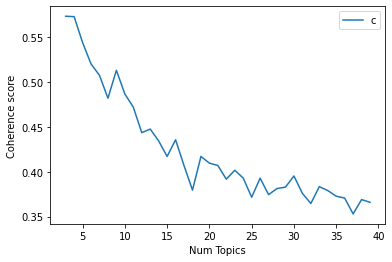

In [ ]:
# Show graph
limit=40; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.5729
Num Topics = 4  has Coherence Value of 0.5725
Num Topics = 5  has Coherence Value of 0.5437
Num Topics = 6  has Coherence Value of 0.5198
Num Topics = 7  has Coherence Value of 0.5072
Num Topics = 8  has Coherence Value of 0.4818
Num Topics = 9  has Coherence Value of 0.5128
Num Topics = 10  has Coherence Value of 0.4864
Num Topics = 11  has Coherence Value of 0.4718
Num Topics = 12  has Coherence Value of 0.4434
Num Topics = 13  has Coherence Value of 0.4474
Num Topics = 14  has Coherence Value of 0.4342
Num Topics = 15  has Coherence Value of 0.417
Num Topics = 16  has Coherence Value of 0.4355
Num Topics = 17  has Coherence Value of 0.4067
Num Topics = 18  has Coherence Value of 0.3795
Num Topics = 19  has Coherence Value of 0.4169
Num Topics = 20  has Coherence Value of 0.4095
Num Topics = 21  has Coherence Value of 0.4069
Num Topics = 22  has Coherence Value of 0.3917
Num Topics = 23  has Coherence Value of 0.4016
Num Topics = 24  has 

In [ ]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))
#print('\nPerplexity: ', lda_model.log_perplexity(corpus))

[(0,
  '0.115*"курс" + 0.061*"очень" + 0.051*"весь" + 0.036*"материал" + '
  '0.035*"отличный" + 0.031*"спасибо" + 0.026*"великий" + 0.023*"задача" + '
  '0.019*"большой" + 0.019*"интересный"'),
 (1,
  '0.025*"много" + 0.023*"неделя" + 0.020*"мочь" + 0.019*"дать" + '
  '0.014*"хорошо" + 0.014*"просто" + 0.013*"видео" + 0.012*"сделать" + '
  '0.012*"работа" + 0.012*"должный"'),
 (2,
  '0.057*"задание" + 0.026*"лекция" + 0.021*"практический" + 0.020*"время" + '
  '0.017*"знание" + 0.016*"программирование" + 0.012*"математика" + '
  '0.012*"понимание" + 0.011*"часть" + 0.011*"метод"'),
 (3,
  '0.121*"курс" + 0.057*"хороший" + 0.035*"обучение" + 0.025*"машинный" + '
  '0.020*"пример" + 0.019*"очень" + 0.019*"тема" + 0.018*"теория" + '
  '0.018*"более" + 0.017*"большой"')]


In [ ]:
import gensim    
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.424803 -0.023208       1        1  26.021370
3     -0.136243  0.167127       2        1  25.521547
2     -0.165182 -0.355758       3        1  24.482022
1     -0.123378  0.211840       4        1  23.975061, topic_info=        Term         Freq        Total Category  logprob  loglift
14     очень   641.000000   641.000000  Default  30.0000  30.0000
59      курс  1941.000000  1941.000000  Default  29.0000  29.0000
26   хороший   486.000000   486.000000  Default  28.0000  28.0000
34      весь   416.000000   416.000000  Default  27.0000  27.0000
4    задание   492.000000   492.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
806  сказать    39.072684    39.072684   Topic4  -5.3404   1.4282
34      весь   399.518189   416.607488   Topic4  -3.0156   1.3863
200  сложный   107.449880   137.888408   Topic4  -4.3288   1.1787
59      курс   764.847781  1941.091110   Topic4  -2.3662   0.4968
102   просто    55.678574   118.004250   Topic4  -4.9862   0.6770

[285 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
28        4  1.001478     автор
1621      2  0.996853  айтишник
30        3  0.995351  алгоритм
319       4  1.001952    анализ
964       3  0.985593    аспект
...     ...       ...       ...
2552      4  1.023733   эмелить
1515      2  0.996853    эффект
403       1  0.994775  являться
130       2  0.996853      язык
913       1  0.994775      ясно

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [ ]:
def format_topics_sentences(ldamodel=model, corpus=corpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,6), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(4)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.338256,"задание, лекция, практический, время, знание, ...","Я получила, хорошее представление о том, что в..."
1,1,2.0,0.443585,"задание, лекция, практический, время, знание, ...",Этот курс подойдет людям с различной начальной...
2,2,2.0,0.418826,"задание, лекция, практический, время, знание, ...","Хороший обзорный курс. Его преимущество в том,..."
3,3,0.0,0.855769,"курс, очень, весь, материал, отличный, спасибо...",ВЕЛИКИЙ! ВЕЛИКИЙ! ВЕЛИКИЙ! ВЕЛИКИЙ! ВЕЛИКИЙ! В...


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(2)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(4)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.855769,"курс, очень, весь, материал, отличный, спасибо...",ВЕЛИКИЙ! ВЕЛИКИЙ! ВЕЛИКИЙ! ВЕЛИКИЙ! ВЕЛИКИЙ! В...
1,0.0,0.398734,"курс, очень, весь, материал, отличный, спасибо...","Очень, очень хороший курс! Нет, он великолепен..."
2,1.0,0.525814,"много, неделя, мочь, дать, хорошо, просто, вид...",Отказ от ответственности: Если вы знакомы с ли...
3,1.0,0.504186,"много, неделя, мочь, дать, хорошо, просто, вид...","Содержание было в порядке, но качество обучени..."


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(4)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"задание, лекция, практический, время, знание, ...",595.0,0.3502
1.0,2.0,"задание, лекция, практический, время, знание, ...",395.0,0.2325
2.0,2.0,"задание, лекция, практический, время, знание, ...",310.0,0.1825
3.0,0.0,"курс, очень, весь, материал, отличный, спасибо...",399.0,0.2348
